In [2]:
import pandas as pd
df = pd.read_pickle("../cri_compustat_merged_v8.pkl")
df.head()

,CompNo,year,month,StkIndx,STInt,dtdlevel,dtdtrend,liqnonfinlevel,liqnonfintrend,ni2talevel,...,day_sales_outstanding,working_capital_turnover,price_to_earnings,dividend_payout_ratio,retention_ratio,gross_margin_ratio,operating_profit_margin,ebitda_margin,debt_service_coverage_ratio,interest_coverage_ratio
0,42404,2000.0,1,0.089239,0.011089,0.677551,0.332808,1.411466,0.027249,-0.148249,...,197946.597222,0.000000,-5.000000,-0.0,1.0,-5.251700e+06,-2.189250e+07,-2.185540e+07,-149041.103448,-297211.000000
1,37610,2000.0,1,0.089239,0.011089,0.087376,-0.524732,0.906364,-0.071829,0.000292,...,190.722132,2.177571,-1.220833,0.0,1.0,2.498284e+01,-7.402171e+01,-6.856532e+01,-0.904380,1.490291
2,49536,2000.0,1,0.313050,0.007314,3.693176,0.625516,1.872712,1.010148,-0.069998,...,0.000000,0.036899,-78.333333,-0.0,1.0,7.542644e+01,-2.309701e+02,-1.503731e+02,-11.081841,-430.222222
3,32417,2000.0,1,0.089239,0.011089,6.165654,0.863910,1.275166,0.184606,0.013360,...,269.176235,0.551135,66.510333,0.0,1.0,5.234158e+01,-2.327468e+01,-1.952816e+01,-395.933333,777.750000
4,44933,2000.0,1,0.089239,0.011089,0.629410,-0.874122,0.000000,0.000000,0.004436,...,0.000000,-2.766467,19.196429,0.0,1.0,7.495250e+01,3.133312e+01,4.316023e+01,0.020216,2.013002


In [3]:
# Unnecessary cols
labels_to_drop = [
    'CompNo',
    'year',
    'month',
    'gvkey',
    'tic',
    'day',
    'date',
    'dummy297fin'
]
df = df.drop(labels_to_drop, axis=1)
df.head()

,StkIndx,STInt,dtdlevel,dtdtrend,liqnonfinlevel,liqnonfintrend,ni2talevel,ni2tatrend,sizelevel,sizetrend,...,day_sales_outstanding,working_capital_turnover,price_to_earnings,dividend_payout_ratio,retention_ratio,gross_margin_ratio,operating_profit_margin,ebitda_margin,debt_service_coverage_ratio,interest_coverage_ratio
0,0.089239,0.011089,0.677551,0.332808,1.411466,0.027249,-0.148249,0.079108,-5.559146,1.222586,...,197946.597222,0.000000,-5.000000,-0.0,1.0,-5.251700e+06,-2.189250e+07,-2.185540e+07,-149041.103448,-297211.000000
1,0.089239,0.011089,0.087376,-0.524732,0.906364,-0.071829,0.000292,0.000139,-2.027446,-0.648054,...,190.722132,2.177571,-1.220833,0.0,1.0,2.498284e+01,-7.402171e+01,-6.856532e+01,-0.904380,1.490291
2,0.313050,0.007314,3.693176,0.625516,1.872712,1.010148,-0.069998,0.038957,1.492078,1.699079,...,0.000000,0.036899,-78.333333,-0.0,1.0,7.542644e+01,-2.309701e+02,-1.503731e+02,-11.081841,-430.222222
3,0.089239,0.011089,6.165654,0.863910,1.275166,0.184606,0.013360,0.000300,0.249383,0.328536,...,269.176235,0.551135,66.510333,0.0,1.0,5.234158e+01,-2.327468e+01,-1.952816e+01,-395.933333,777.750000
4,0.089239,0.011089,0.629410,-0.874122,0.000000,0.000000,0.004436,-0.007812,-2.133248,-0.210920,...,0.000000,-2.766467,19.196429,0.0,1.0,7.495250e+01,3.133312e+01,4.316023e+01,0.020216,2.013002


In [4]:
print(pd.__version__)

1.4.4


In [5]:
# Format Event Type col
#df = df[df['EventType'] != 2]
df['Default'] = df['Default'].apply(lambda x: '1' if x == 1 else '0')
df['Default'].value_counts()

0    1170092
1       9322
Name: Default, dtype: int64

In [6]:
# Format Duration col
df['Duration'] = df['Duration'].astype(str)
df['Duration'] = df['Duration'].str.replace(r'\s', '', regex=True)
df['Duration'] = df['Duration'].str.split('days').str[0]
df['Duration'] = df['Duration'].astype('float32')

In [7]:
from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv
import numpy as np
import torchtuples as tt

In [8]:
# Split into train,test, validation
df_train = df
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper 
og_cols = df_train.columns.tolist()
cols_standardize = [i for i in og_cols if i not in ['Duration', 'Default']]
cols_leave =[]

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [10]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

In [11]:
# Discretize time column
num_durations = 10

labtrans = DeepHitSingle.label_transform(num_durations)

get_target = lambda df: (df['Duration'].values, df['Default'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

In [12]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)
model = DeepHitSingle(net, tt.optim.Adam, alpha=0.2, sigma=0.1, duration_index=labtrans.cuts)

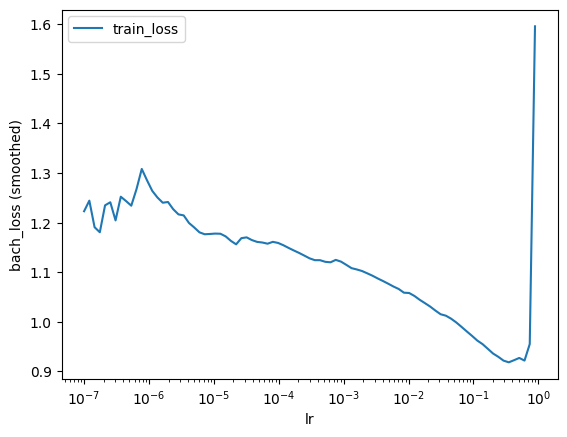

In [13]:
batch_size = 256
lr_finder = model.lr_finder(x_train, y_train, batch_size, tolerance=3)
_ = lr_finder.plot()

In [14]:
lr_finder.get_best_lr()

0.035111917342151515

In [15]:
model.optimizer.set_lr(0.01)

In [16]:
epochs = 100
callbacks = [tt.callbacks.EarlyStopping()]
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[38s / 38s],		train_loss: 0.1307,	val_loss: 0.0639
1:	[38s / 1m:16s],		train_loss: 0.0917,	val_loss: 0.0487
2:	[35s / 1m:52s],		train_loss: 0.0748,	val_loss: 0.1094
3:	[35s / 2m:27s],		train_loss: 0.0703,	val_loss: 0.0375
4:	[34s / 3m:2s],		train_loss: 0.0717,	val_loss: 0.0431
5:	[34s / 3m:37s],		train_loss: 0.0649,	val_loss: 0.0274
6:	[34s / 4m:11s],		train_loss: 0.0574,	val_loss: 0.0525
7:	[34s / 4m:46s],		train_loss: 0.0540,	val_loss: 0.0394
8:	[34s / 5m:20s],		train_loss: 0.0620,	val_loss: 0.0417
9:	[34s / 5m:54s],		train_loss: 0.0598,	val_loss: 0.0296
10:	[34s / 6m:29s],		train_loss: 0.0511,	val_loss: 0.0285
11:	[34s / 7m:3s],		train_loss: 0.0485,	val_loss: 0.0215
12:	[34s / 7m:37s],		train_loss: 0.0482,	val_loss: 0.0347
13:	[34s / 8m:12s],		train_loss: 0.0448,	val_loss: 0.0257
14:	[34s / 8m:46s],		train_loss: 0.0447,	val_loss: 0.0326
15:	[34s / 9m:21s],		train_loss: 0.0463,	val_loss: 0.0263
16:	[34s / 9m:55s],		train_loss: 0.0406,	val_loss: 0.0309
17:	[34s / 10m:29s],		train_l

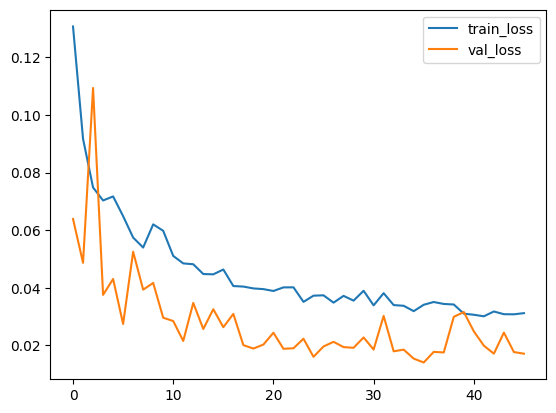

In [17]:
_ = log.plot()

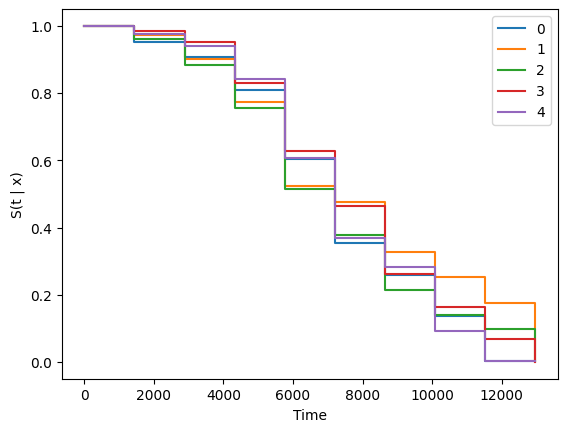

In [23]:
import matplotlib.pyplot as plt
surv = model.predict_surv_df(x_test)
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [24]:
surv = model.interpolate(10).predict_surv_df(x_test)

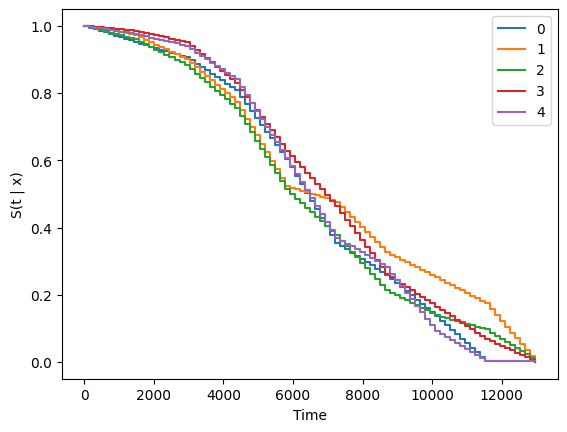

In [25]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

ROC AUC

check the test_pred df to see if it has good results

In [17]:
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
surv = model.predict_surv_df(x_test)
surv.shape

(10, 235883)

In [18]:
test_pred = np.array(surv.iloc[9])
test_pred_binary = np.round(test_pred).astype(int)
test_true = df_test['Default'].to_numpy().astype(int)

In [19]:
accuracy = accuracy_score(test_true, test_pred_binary)
recall = recall_score(test_true, test_pred_binary)
precision = precision_score(test_true, test_pred_binary)
f1 = f1_score(test_true, test_pred_binary)
auc = roc_auc_score(df_test['Default'], test_pred)
confusion = confusion_matrix(test_true, test_pred_binary)

print('Accuracy:', accuracy)
print('Recall:', recall)
print('Precision:', precision)
print('F1 Score:', f1)
print('AUC:', auc)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.9921401711865628
Recall: 0.0
Precision: 0.0
F1 Score: 0.0
AUC: 0.45920244175567865


Older Metrics

In [20]:
ev = EvalSurv(surv, durations_test, events_test.astype(int), censor_surv='km')

In [21]:
ev.concordance_td('antolini')

: 

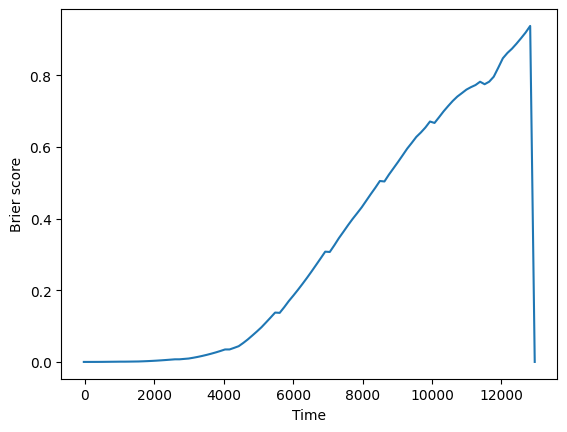

In [28]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

In [29]:
ev.integrated_brier_score(time_grid) 

0.3276582120912859

In [34]:
ev.integrated_nbll(time_grid) 

0.9629183060663509